In [1]:
%matplotlib widget
import ipywidgets as widgets
import numpy as np
import matplotlib.pyplot as plt


### **Sdf examples**

We define some simple sdf function in 1D:

In [2]:
def one_point(x):
    return -x


def one_wall(x):
    return np.abs(x) - 0.5


def two_walls(x):
    return np.minimum(np.abs(x - 0.5) - 0.25, np.abs(x + 0.5) - 0.25)


sdfs = {"one_point": one_point, "one_wall": one_wall, "two_walls": two_walls}

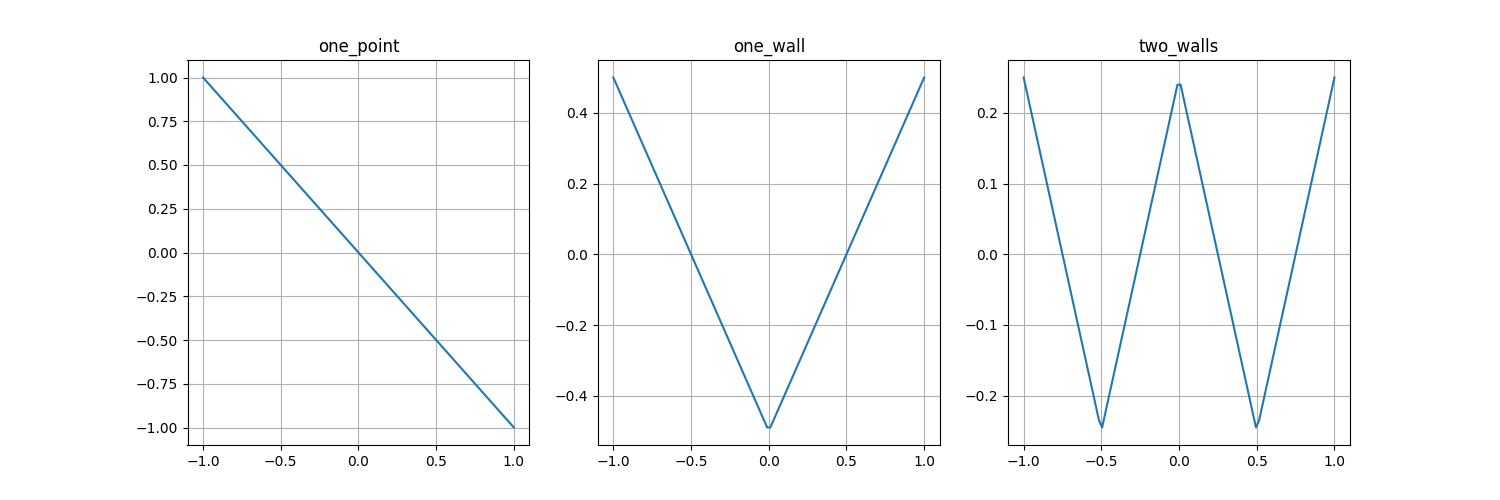

In [3]:
x = np.linspace(-1, 1, 100)

fig, axes = plt.subplots(1, len(sdfs), figsize=(5 * len(sdfs), 5))
for ax, (name, sdf) in zip(axes, sdfs.items()):
    ax.plot(x, sdf(x))
    ax.set_title(name)
    ax.grid(True)

### **Naive solution**
#### Definition
First, we implement the *S density* function $\phi_s(f(x))$:
$$\phi_s(x) = se^{-sx}/(1+e^{-sx})^2,$$
which is the derivative of the *Sigmoid* function $\Phi_s(x) = (1+e^{-sx})^{-1}$. $s$ is a **trainiable parameter** here.

In [4]:
def s_density(sdf, s=1):
    e_sx = np.exp(-s * sdf)
    return (s * e_sx) / (1 + e_sx) ** 2


def sigmoid(x, s=1):
    return 1 / (1 + np.exp(-s * x))

Then we implement the weight, first the **naive solution**:
$$w(t) = T(t)\sigma(t),$$
The *accumulated transmittance* $T$ is computed as:
$$T(t) = \exp(-\int_0^t\sigma(u)du).$$
The *volume density* is set to be equal to the S density.

In [5]:
def transmittance(x, density):
    dx = np.gradient(x)
    integral = np.cumsum(dx * density)
    return np.exp(-integral)


def weight(T, density):
    return T * density

#### Visualization

interactive(children=(FloatSlider(value=1.0, description='s', max=10.0), Dropdown(description='sdf', options={…

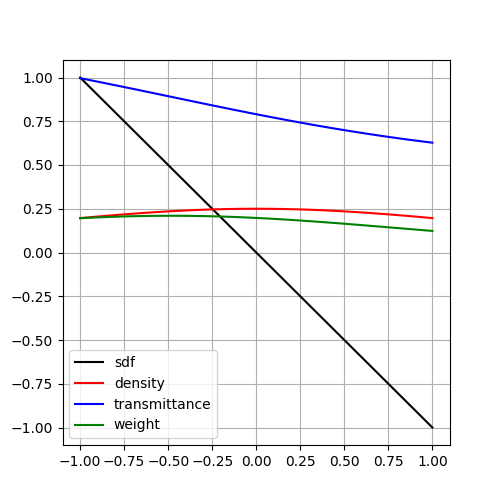

In [6]:
fig = plt.figure(figsize=(5, 5))
ax = fig.add_subplot(111)

# Parameters
s = 1.0
sdf = sdfs["one_point"]

x = np.linspace(-1, 1, 100)
sdf_val = sdf(x)
density_val = s_density(sdf_val, s)
transmittance_val = transmittance(x, density_val)
weight_val = weight(transmittance_val, density_val)

(sdf_line,) = ax.plot(x, sdf_val, "k-", label="sdf")
(density_line,) = ax.plot(x, density_val, "r-", label="density")
(transmittance_line,) = ax.plot(x, transmittance_val, "b-", label="transmittance")
(weight_line,) = ax.plot(x, weight_val, "g-", label="weight")

ax.legend()
ax.grid()


def update(
    s=widgets.FloatSlider(min=0, max=10, step=0.1, value=s),
    sdf=widgets.Dropdown(options=sdfs, value=sdf),
):
    sdf_val = sdf(x)
    density_val = s_density(sdf_val, s)
    transmittance_val = transmittance(x, density_val)
    weight_val = weight(transmittance_val, density_val)

    sdf_line.set_ydata(sdf_val)
    density_line.set_ydata(density_val)
    transmittance_line.set_ydata(transmittance_val)
    weight_line.set_ydata(weight_val)

    fig.canvas.draw_idle()


_ = widgets.interact(update)

### **Normalized S-density**
#### Definition
Another naive way is to define the weight to be the normalized S-density:
$$w(t) = \dfrac{\phi_s(f(\boldsymbol{p}(t)))}{\int_0^{+\infty}\phi_s(f(\boldsymbol{p}(u)))du}.$$

In [7]:
def normalized_density(x, density):
    dx = np.gradient(x)
    integral = np.sum(density * dx)
    return density / (integral + 1e-8)

#### Visualization

interactive(children=(FloatSlider(value=1.0, description='s', max=10.0), Dropdown(description='sdf', options={…

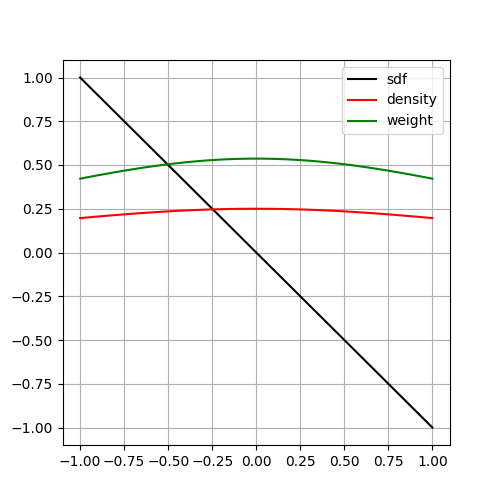

In [8]:
fig = plt.figure(figsize=(5, 5))
ax = fig.add_subplot(111)

# Parameters
s = 1.0
sdf = sdfs["one_point"]

x = np.linspace(-1, 1, 100)
sdf_val = sdf(x)
density_val = s_density(sdf_val, s)
weight_val = normalized_density(x, density_val)

(sdf_line,) = ax.plot(x, sdf_val, "k-", label="sdf")
(density_line,) = ax.plot(x, density_val, "r-", label="density")
(weight_line,) = ax.plot(x, weight_val, "g-", label="weight")

ax.legend()
ax.grid()


def update(
    s=widgets.FloatSlider(min=0, max=10, step=0.1, value=s),
    sdf=widgets.Dropdown(options=sdfs, value=sdf),
):
    sdf_val = sdf(x)
    density_val = s_density(sdf_val, s)
    weight_val = normalized_density(x, density_val)

    sdf_line.set_ydata(sdf_val)
    density_line.set_ydata(density_val)

    weight_line.set_ydata(weight_val)

    fig.canvas.draw_idle()


_ = widgets.interact(update)

### **Neus solution**
The weight of neus solution is computed as:
$$w(t) = T(t)\rho(t).$$
We first introduce the *opaque density* function $\rho(t)$:
$$\rho(t) = \max\left(\dfrac{-\frac{d\Phi_s}{dt}(f(\boldsymbol{p}(t)))}{\Phi_s(f(\boldsymbol{p}(t)))},0\right).$$


In [9]:
def opaque_density(x, sdf, s=1, dx_dt=1):
    sigmoid_sdf = sigmoid(sdf, s)
    derivative = np.gradient(sigmoid_sdf, x)
    return np.maximum((-derivative * dx_dt) / sigmoid_sdf, 0)

The transmittance is computed using the similar formula:
$$T(t) = \exp(-\int_0^t\rho(u)du).$$

#### Visualization

interactive(children=(FloatSlider(value=1.0, description='s', max=10.0), Dropdown(description='sdf', options={…

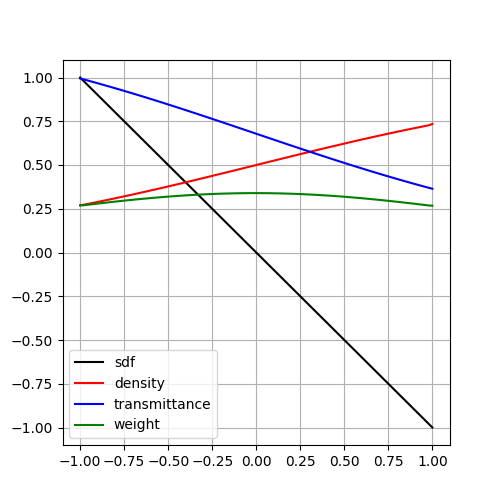

In [10]:
fig = plt.figure(figsize=(5, 5))
ax = fig.add_subplot(111)

# Parameters
s = 1.0
sdf = sdfs["one_point"]

x = np.linspace(-1, 1, 100)
sdf_val = sdf(x)
density_val = opaque_density(x, sdf_val, s)
transmittance_val = transmittance(x, density_val)
weight_val = weight(transmittance_val, density_val)

(sdf_line,) = ax.plot(x, sdf_val, "k-", label="sdf")
(density_line,) = ax.plot(x, density_val, "r-", label="density")
(transmittance_line,) = ax.plot(x, transmittance_val, "b-", label="transmittance")
(weight_line,) = ax.plot(x, weight_val, "g-", label="weight")

ax.legend()
ax.grid()


def update(
    s=widgets.FloatSlider(min=0, max=10, step=0.1, value=s),
    sdf=widgets.Dropdown(options=sdfs, value=sdf),
):
    sdf_val = sdf(x)
    density_val = opaque_density(x, sdf_val, s)
    transmittance_val = transmittance(x, density_val)
    weight_val = weight(transmittance_val, density_val)

    sdf_line.set_ydata(sdf_val)
    density_line.set_ydata(density_val)
    transmittance_line.set_ydata(transmittance_val)
    weight_line.set_ydata(weight_val)

    fig.canvas.draw_idle()


_ = widgets.interact(update)

### **Volsdf solution**
In Volsdf and monosdf, the density is defined as:
$$\sigma_{\beta}(s)=\left\{\begin{array}{ll}
\frac{1}{2 \beta} \exp \left(-\frac{s}{\beta}\right) & \text { if } s \leq 0 \\
\frac{1}{\beta}\left(1-\frac{1}{2} \exp \left(\frac{s}{\beta}\right)\right) & \text { if } s>0
\end{array}\right..$$

In [11]:
def beta_density(sdf, beta=0.1):
    beta += 1e-8
    return (0.5 + 0.5 * np.sign(sdf) * np.expm1(-np.abs(sdf) / beta)) / beta

The transmittance $T$ and alpha $\alpha$ are computed similar as in desity NeRF as:
$$T^{i}=\prod_{j=1}^{i-1}\left(1-\alpha^{j}\right) \quad \alpha^{i}=1-\exp \left(-\sigma^{i} \delta^{i}\right),$$
where $\delta$ is the distance between neighboring sample points.

In [12]:
def alpha(x, density):
    dx = np.gradient(x)
    return 1 - np.exp(-density * dx)


def transmittance_prod(alpha):
    return np.cumprod(1 - alpha)

The weight is computed as the product of the transmittance and the alpha:
$$w^i = T^i\alpha^i.$$

#### Visualization

interactive(children=(FloatLogSlider(value=1.0, description='beta', max=0.0, min=-6.0), Dropdown(description='…

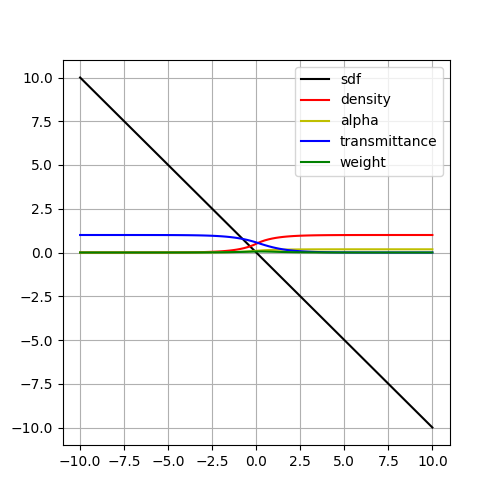

In [13]:
fig = plt.figure(figsize=(5, 5))
ax = fig.add_subplot(111)

# Parameters
beta = 1
sdf = sdfs["one_point"]

x = np.linspace(-1, 1, 100)
sdf_val = sdf(x)
density_val = beta_density(sdf_val, beta)
alpha_val = alpha(x, density_val)
transmittance_val = transmittance_prod(alpha_val)
weight_val = weight(transmittance_val, alpha_val)

(sdf_line,) = ax.plot(x, sdf_val, "k-", label="sdf")
(density_line,) = ax.plot(x, density_val, "r-", label="density")
(alpha_line,) = ax.plot(x, alpha_val, "y-", label="alpha")
(transmittance_line,) = ax.plot(x, transmittance_val, "b-", label="transmittance")
(weight_line,) = ax.plot(x, weight_val, "g-", label="weight")

ax.legend()
ax.grid()


def update(
    beta=widgets.FloatLogSlider(base=10, min=-6, max=0, step=0.1, value=beta),
    sdf=widgets.Dropdown(options=sdfs, value=sdf),
):
    sdf_val = sdf(x)
    density_val = beta_density(sdf_val, beta)
    alpha_val = alpha(x, density_val)
    transmittance_val = transmittance_prod(alpha_val)
    weight_val = weight(transmittance_val, alpha_val)

    sdf_line.set_ydata(sdf_val)
    density_line.set_ydata(density_val)
    alpha_line.set_ydata(alpha_val)
    transmittance_line.set_ydata(transmittance_val)
    weight_line.set_ydata(weight_val)

    fig.canvas.draw_idle()


_ = widgets.interact(update)